### GROUP 8 members:
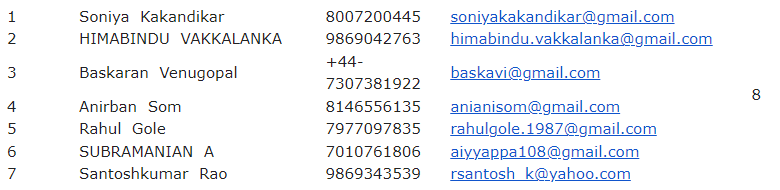

## Overview: Built classification models using multiple algorithms to predict NPS status. The notebook is divided into 2 major parts as follows - 
### Part 1: Classification models without over/undersampling techniques
### Part 2: SMOTE Random forest and Logistic regression classification model i.e. with over-sampling technique
##### Note: Oversampling is considered due to highly imbalance class distribution 
##### Note: SMOTE - Synthetic Minority Over-sampling Technique

### Table of content:
#### 1. Data wrangling and EDA for data understanding
#### 2. Target variable distribution
#### 3. Data pre-processing
#### 3.1. Data encoding and scaling (standardization and normalization)
#### 3.2. Train valid split
#### 4. Feature selection
#### 5. Part 1: Classification models without oversampling techniques & model performance metrics
##### 5.1. KNN, Decision Tree & Random forest
#### 6. Part 2: Classification model with over-sampling techniques & model performance metrics
##### 6.1. SMOTE Random foreset, SMOTE adaboost regression
### 7. Final conclusion / Recommendation
#### 8. SHAP values & partial dependence plots for model evaluation

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from mlxtend.preprocessing import minmax_scaling

import plotly.graph_objects as go
#import plotly.subplots as sp
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from IPython.display import HTML, display, Markdown, clear_output

from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from statistics import mean
from sklearn import metrics
import matplotlib.pyplot as plt
 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.inspection import PartialDependenceDisplay

%matplotlib inline

### Data wrangling 

In [2]:
nps=pd.read_csv('nps_train.csv')
nps = nps.rename(columns=lambda s: s.replace(" ", "_"))
nps

,SN,HospitalNo2,MaritalStatus,AgeYrs,Sex,BedCategory,Department,Estimatedcost,InsPayorcategory,State,...,OVS_OVERALLSTAFFPROMPTNESS,OVS_SECURITYATTITUDE,DP_DISCHARGETIME,DP_DISCHARGEQUERIES,DP_DISCHARGEPROCESS,AdmissionDate,DischargeDate,LengthofStay,CE_NPS,NPS_Status
0,1,35236,Single,4.0,F,SPECIAL,PEDIATRIC,25000.0,PATIENT,Karnataka,...,4,4,4,4,4,18-07-2014,21-07-2014,3,9,Promotor
1,2,35237,Single,13.0,F,SPECIAL,PEDIATRIC,15000.0,PATIENT,Karnataka,...,4,4,4,4,4,11-07-2014,16-07-2014,5,10,Promotor
2,3,35234,Married,33.0,F,SEMISPECIAL,GYNAEC,70000.0,EXEMPTION,Karnataka,...,4,4,3,4,3,17-06-2014,20-07-2014,33,7,Passive
3,4,35232,Married,51.0,F,SPECIAL,GYNAEC,150000.0,PATIENT,West Bengal,...,3,3,3,4,3,16-07-2014,22-07-2014,6,10,Promotor
4,5,35233,Married,31.0,F,SPECIAL,GYNAEC,100000.0,INSURANCE,Karnataka,...,4,4,4,4,4,13-07-2014,16-07-2014,3,10,Promotor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,4985,5630,Single,1.0,F,SEMISPECIAL,PEDIATRIC,20000.0,INSURANCE,Karnataka,...,4,4,3,3,3,10-03-2014,12-03-2014,2,6,Detractor
4985,4986,8481,Single,6.0,F,SEMISPECIAL,GEN,70000.0,PATIENT,Karnataka,...,4,4,4,4,4,15-04-2014,18-04-2014,3,9,Promotor
4986,4987,8483,Married,50.0,F,SEMISPECIAL,GEN,45000.0,INSURANCE,Karnataka,...,4,4,3,4,3,16-04-2014,18-04-2014,2,10,Promotor
4987,4988,8485,Single,21.0,M,GENERAL,GEN,40000.0,PATIENT,Karnataka,...,3,3,3,3,3,14-04-2014,18-04-2014,4,8,Passive


### Checking for data distributions 

In [3]:
# Distribution of Return Status considering all orders
nps_dist=nps.groupby(['NPS_Status']).size().reset_index().rename({0:'cnt_status'},axis=1)
nps_dist['pct_each_class']=round(nps_dist['cnt_status']*100/len(nps),2)
nps_dist['pct_each_class']=nps_dist['pct_each_class'].apply(lambda x:str(x)+' %')
nps_dist_plt=px.bar(nps_dist,x='NPS_Status',y='cnt_status',text='pct_each_class',title='NPS Status distribution')
nps_dist_plt.update_layout(
                        autosize=False,
                        width=500,
                        height=400)
nps_dist_plt.show()

##### Note: There is class imbalance of the target variable 

### Bivarate analysis 

In [4]:
#nps.columns

nps_data=nps.copy()

## List of columns selected for modelling

cat_cols=nps[[ 'AgeYrs', 'Estimatedcost']]


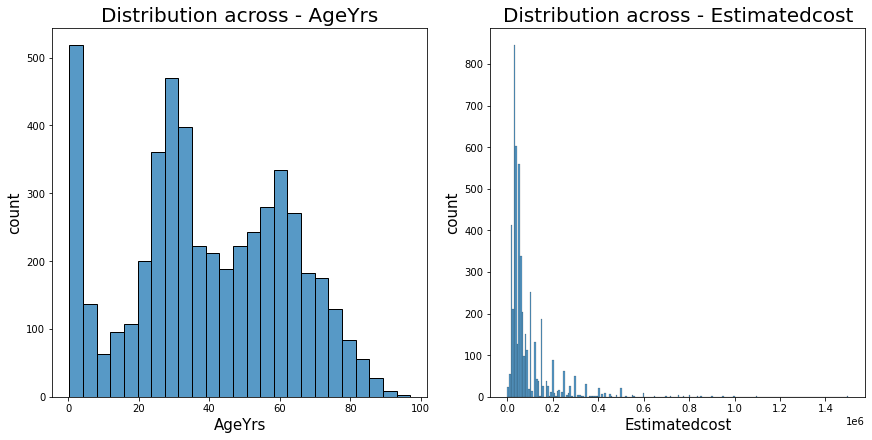

In [5]:
if len(cat_cols.columns)%2!=0:
    nrows=(len(cat_cols.columns)//2)+1
else:
    nrows=(len(cat_cols.columns)//2)
figure, axes = plt.subplots(nrows, 2,figsize=(12, 6), constrained_layout=True)
col_list=cat_cols.columns
nrow=0
#figure.suptitle('UNIVARIATE DISTRIBUTION', fontsize=)
for i in range(len(col_list)):
    ncol=i%2
    if((cat_cols[col_list[i]].dtype=='O')|((cat_cols[col_list[i]].dtype!='O')&(cat_cols[col_list[i]].nunique()<10))):
        nps_dist=nps.groupby([col_list[i]]).size().reset_index().rename({0:'cnt_status'},axis=1)
        nps_dist['pct_each_class']=round(nps_dist['cnt_status']*100/len(nps),2)
        nps_dist['pct_each_class']=nps_dist['pct_each_class'].apply(lambda x:str(x)+' %')
        b=sns.barplot(data=nps_dist,x=col_list[i],y='cnt_status',ax=axes[nrow][ncol])
        b.axes.set_title(cnt_status,fontsize=50)
        b.set_xlabel(col_list[i],fontsize=15)
        b.set_ylabel("cnt_status",fontsize=15)
        b.tick_params(labelsize=10)
    else:
        c=sns.histplot(data=cat_cols,x=col_list[i],ax=axes[ncol])
        c.set_xlabel(col_list[i],fontsize=15)
        c.set_ylabel("count",fontsize=15)
        c.tick_params(labelsize=10)
        
    axes[ncol].set_title('Distribution across - '+col_list[i], fontsize=20)
    if(ncol==1):
        nrow+=1
        
if len(cat_cols.columns)%2!=0:
    axes.flat[-1].set_visible(False)

In [37]:
# Checking Return status distribution for categorical features
cat_vars=['MaritalStatus', 'Sex', 'BedCategory',
       'Department', 'InsPayorcategory',
       'STATEZONE', 'CE_ACCESSIBILITY', 'CE_CSAT', 'CE_VALUEFORMONEY','EM_NURSING', 'EM_DOCTOR',
       'AD_STAFFATTITUDE','INR_ROOMAMBIENCE', 'FNB_FOODQUALITY',
       'FNB_DIETICIAN',
       'DOC_ATTITUDE', 'DOC_TREATMENTEFFECTIVENESS','OVS_OVERALLSTAFFATTITUDE',
       'OVS_OVERALLSTAFFPROMPTNESS','DP_DISCHARGEPROCESS','LengthofStay']

def cat_return_link(df,var):
    cat_type=df.groupby([var]+['NPS_Status']).size().reset_index().rename({0:'cnt_status'},axis=1)
    cat_type['pct_NPS_Status']=((cat_type['cnt_status'].astype(float))*100/len(nps)).round(2)
    cat_type=cat_type[[var]+['NPS_Status','pct_NPS_Status']]
    cat_plt=px.bar(cat_type,color='NPS_Status',y='pct_NPS_Status',
                x=var,barmode='relative',text='pct_NPS_Status',title='NPS Status % distribution for - '+var)
    cat_plt.update_layout(
                        autosize=False,
                        width=700,
                        height=350)
    cat_plt.show()
    
for i in cat_vars:
    cat_return_link(nps,i)

##### Note: There is a lot of data imbalance for almost all of the columns and bagging/boosting algorithms would work good for this dataset.


### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Data pre-processing 
### One hot encoding and label encoding
### Scaling (standardization and normalization)

#### Data preparation for modelling

In [7]:
## List of columns for dummy/one-hot encoding
nps_data_dummy=nps_data[['MaritalStatus','Sex','BedCategory','Department','InsPayorcategory','State', 'Country','STATEZONE']]

## List of column(s) for label encoding
nps_data_lab=nps_data[['CE_ACCESSIBILITY', 'CE_CSAT', 'CE_VALUEFORMONEY',
       'EM_IMMEDIATEATTENTION', 'EM_NURSING', 'EM_DOCTOR', 'EM_OVERALL',
       'AD_TIME', 'AD_TARRIFFPACKAGESEXPLAINATION', 'AD_STAFFATTITUDE',
       'INR_ROOMCLEANLINESS', 'INR_ROOMPEACE', 'INR_ROOMEQUIPMENT',
       'INR_ROOMAMBIENCE', 'FNB_FOODQUALITY', 'FNB_FOODDELIVERYTIME',
       'FNB_DIETICIAN', 'FNB_STAFFATTITUDE', 'AE_ATTENDEECARE',
       'AE_PATIENTSTATUSINFO', 'AE_ATTENDEEFOOD', 'DOC_TREATMENTEXPLAINATION',
       'DOC_ATTITUDE', 'DOC_VISITS', 'DOC_TREATMENTEFFECTIVENESS',
       'NS_CALLBELLRESPONSE', 'NS_NURSESATTITUDE', 'NS_NURSEPROACTIVENESS',
       'NS_NURSEPATIENCE', 'OVS_OVERALLSTAFFATTITUDE',
       'OVS_OVERALLSTAFFPROMPTNESS', 'OVS_SECURITYATTITUDE',
       'DP_DISCHARGETIME', 'DP_DISCHARGEQUERIES', 'DP_DISCHARGEPROCESS']]

## List of numerical columns for scaling 
nps_data_sc=nps_data[['AgeYrs','Estimatedcost','LengthofStay']]

## Performed min-max scaling on the list of numerical columns
nps_data_sc_minmaxsc=minmax_scaling(nps_data_sc, columns=['AgeYrs','Estimatedcost','LengthofStay'])

nps_data_dumm_enc=pd.get_dummies(nps_data_dummy
                                           ,columns=nps_data_dummy.columns
                                           ,drop_first=True)

## Joined dummy encoded - min max scaled - label encoded dataset and created a the final encoded modelling dataset
nps_dumm_lab=pd.merge(nps_data_dumm_enc,nps_data_lab,left_index=True,right_index=True)

nps_enc_cols=pd.merge(nps_dumm_lab,
                       nps_data_sc_minmaxsc,
                       left_index=True,right_index=True)

nps_data_y=nps_data[['NPS_Status']]

nps_enc_cols_y=pd.merge(nps_enc_cols,
                       nps_data_y,
                       left_index=True,right_index=True)
nps_enc_cols_y

,MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Single,MaritalStatus_Widowed,Sex_M,BedCategory_DAYCARE,BedCategory_GENERAL,BedCategory_GENERAL HD,BedCategory_ITU,BedCategory_Renal ICU,...,OVS_OVERALLSTAFFATTITUDE,OVS_OVERALLSTAFFPROMPTNESS,OVS_SECURITYATTITUDE,DP_DISCHARGETIME,DP_DISCHARGEQUERIES,DP_DISCHARGEPROCESS,AgeYrs,Estimatedcost,LengthofStay,NPS_Status
0,0,0,1,0,0,0,0,0,0,0,...,4,4,4,4,4,4,0.038263,0.016667,0.0375,Promotor
1,0,0,1,0,0,0,0,0,0,0,...,4,4,4,4,4,4,0.131334,0.010000,0.0625,Promotor
2,1,0,0,0,0,0,0,0,0,0,...,4,4,4,3,4,3,0.338159,0.046667,0.4125,Passive
3,1,0,0,0,0,0,0,0,0,0,...,4,3,3,3,4,3,0.524302,0.100000,0.0750,Promotor
4,1,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,0.317477,0.066667,0.0375,Promotor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4984,0,0,1,0,0,0,0,0,0,0,...,4,4,4,3,3,3,0.007239,0.013333,0.0250,Detractor
4985,0,0,1,0,0,0,0,0,0,0,...,4,4,4,4,4,4,0.058945,0.046667,0.0375,Promotor
4986,1,0,0,0,0,0,0,0,0,0,...,4,4,4,3,4,3,0.513961,0.030000,0.0250,Promotor
4987,0,0,1,0,1,0,1,0,0,0,...,3,3,3,3,3,3,0.214064,0.026667,0.0500,Passive


### Test train split 
#### Y variable selection

In [8]:
## Target variable selection and split % 
target_var='NPS_Status'
split_percentage=15

## X and y seperation
split_perc=split_percentage/100
X=nps_enc_cols_y.loc[:,nps_enc_cols_y.columns]
y=nps_enc_cols_y[target_var]
X=X.drop(target_var,axis=1)

## Splitting the data for modelling (without oversampling)
x_train,x_valid,y_train,y_valid=train_test_split(X,y,test_size=split_perc,random_state=0)

print("Training-Validation Split Percentage:{split}".format(split=int((1-split_perc)*100)))
print("Total Observation:{obs}".format(obs=X.shape[0]))
print("Training Observation:{train_obs}".format(train_obs=x_train.shape[0]))
print("Validation Observation:{valid_obs}".format(valid_obs=x_valid.shape[0]))

Training-Validation Split Percentage:85
Total Observation:4989
Training Observation:4240
Validation Observation:749


## Feature engineering & selection
### Multi colinearity check and column drop

In [9]:
def multi_collinear(x_train_processed):
    truncate_value=15
    exog_df=x_train_processed.loc[:,x_train_processed.columns!=target_var]
    exog_df=x_train_processed.copy()
    
    exog_df=add_constant(exog_df)
    vifs=pd.Series([1/(1.-OLS(exog_df[col].values,
                              exog_df.loc[:,exog_df.columns!=col].values).fit().rsquared) for col in exog_df],
                   index=exog_df.columns,
                   name='VIF')
    
    vifs=pd.DataFrame(vifs)
    vifs.drop('const',axis=0,inplace=True)
    vifs=vifs['VIF'].where(vifs['VIF']<=truncate_value,truncate_value)
    vifs=pd.DataFrame(vifs)
    vifs_df=vifs.sort_values(by=['VIF'],ascending=True)
    
    vifs_df['colors']=np.where(vifs_df.VIF<=5,'yellowgreen',
                                 np.where((vifs_df.VIF>5) & (vifs_df.VIF<=10),'steelblue','tomato'))
    
    Layout=go.Layout(title="VIF plot", xaxis=dict(title='VIF'),yaxis=dict(title='Features'))
    fig=go.Figure(go.Bar(x=vifs_df.VIF,y=vifs_df.index.tolist(),
                         orientation='h',marker_color=vifs_df['colors']),layout=Layout)
    fig.add_shape(type="line",x0=5,y0=0,x1=5,y1=len(vifs_df.index.tolist()),
                  line=dict(color="midnightblue",width=2,dash="dot"))
    fig.add_shape(type="line",x0=10,y0=0,x1=10,y1=len(vifs_df.index.tolist()),
                  line=dict(color="midnightblue",width=2,dash="dot"))
    
    fig.update_layout(width=800,height=800)
    fig.show(config={'displaylogo':False})
    return vifs

vifs=multi_collinear(x_train)


def multi_col_vars(vifs):
    multicorr_vars=vifs['VIF'].loc[lambda x:x>=10].index.tolist()
    col_to_drop=multicorr_vars
    
    if col_to_drop==[]:
        #clear_output()
        print("No columns were dropped")
    else:
        #clear_output()
        x_train.drop(col_to_drop,axis=1,inplace=True)
        display(Markdown('Successfully dropped:{}'.format(",".join(col_to_drop))))
        
        display(x_train.dtypes)
    return x_train


x_train=multi_col_vars(vifs)

Successfully dropped:MaritalStatus_Married,MaritalStatus_Separated,MaritalStatus_Single,MaritalStatus_Widowed,BedCategory_DAYCARE,BedCategory_GENERAL,BedCategory_GENERAL HD,BedCategory_ITU,BedCategory_Renal ICU,BedCategory_SEMISPECIAL,BedCategory_SEMISPECIAL HD,BedCategory_SPECIAL,BedCategory_ULTRA DLX,BedCategory_ULTRA SPL,State_Andaman And Nicobar,State_Andhra Pradesh,State_Assam,State_Bangladesh,State_Bhubaneshwar,State_Bihar,State_Chandigarh,State_Chhattisgarh,State_Darjeeling,State_Delhi,State_Doha,State_Germany,State_Goa,State_Gujarat,State_Haryana,State_International,State_Iraq,State_Jharkand,State_Jharkhand,State_Karnataka,State_Kenya,State_Kerala,State_Kolkata,State_Kolkatta,State_Madhya Pradesh,State_Maharashtra,State_Maldives,State_Manipur,State_Mauritius,State_Meghalaya,State_Mizoram,State_Mongolia,State_Mumbai,State_Muscat,State_Nepal,State_New Zealand,State_Nigeria,State_Oman,State_Ontario,State_Orissa,State_RWANDA,State_Rajasthan,State_Ranchi,State_Saudi Arabia,State_Sikkim,State_Tamil Nadu,State_Tanzania,State_Tripura,State_UAE,State_UK,State_USA,State_Unknown,State_Uttar Pradesh,State_Uttarakhand,State_West Bengal,State_Zimbabwe,Country_Africa,Country_BANGLADESH,Country_CANADA,Country_GERMANY,Country_INDIA,Country_IRAQ,Country_KENYA,Country_MALDIVES,Country_MAURITIUS,Country_MONGOLIA,Country_MOZAMBIQUE,Country_NEW ZEALAND,Country_NIGERIA,Country_OMAN,Country_QATAR,Country_SAUDI ARABIA,Country_Saudi Arabia,Country_UGANDA,Country_UNITED ARAB EMIRATES,Country_UNITED KINGDOM,Country_UNITED REPUBLIC OF TANZANIA,Country_UNITED STATES OF AMERICA,Country_ZIMBABWE,STATEZONE_EAST,STATEZONE_INTERNATIONAL,STATEZONE_NORTH,STATEZONE_SOUTH,STATEZONE_Unknown,STATEZONE_WEST

Sex_M                                 uint8
Department_GEN                        uint8
Department_GYNAEC                     uint8
Department_ORTHO                      uint8
Department_PEDIATRIC                  uint8
Department_RENAL                      uint8
Department_SPECIAL                    uint8
InsPayorcategory_EXEMPTION            uint8
InsPayorcategory_INSURANCE            uint8
InsPayorcategory_INTERNATIONAL        uint8
InsPayorcategory_PATIENT              uint8
Country_FIJI                          uint8
Country_ISLAMIC REPUBLIC OF IRAN      uint8
Country_NEPAL                         uint8
Country_SUDAN                         uint8
Country_YEMEN                         uint8
CE_ACCESSIBILITY                      int64
CE_CSAT                               int64
CE_VALUEFORMONEY                      int64
EM_IMMEDIATEATTENTION                 int64
EM_NURSING                            int64
EM_DOCTOR                             int64
EM_OVERALL                      

### Variability check

In [10]:
## Chceking variability between the column values
def variability(x_train):
    selected_features=[]
    selected_features_dict={}
    col_drop=[]
    zero_variance=(x_train.describe().loc['std']==0)
    zero_variance=zero_variance[zero_variance].index.tolist()
    if len(zero_variance)==0:
        print('No columns with 0 std dev.')
    else:
        display(pd.DataFrame(zero_varinace,columns=['Features']))
        col_drop.extend(zero_variance)
    return selected_features,selected_features_dict,col_drop

variability(x_train)

No columns with 0 std dev.


([], {}, [])

In [11]:
## Filtering the list of columns in the x_test dataframe as per the x_train VIF removed columns
## here x_test is x_valid dataset 

x_test=[]
for i in x_train:
    if i in x_valid:
        x_test.append(i)
        
x_test=x_valid[x_test]
#x_test

### Feature importance check using Random forest

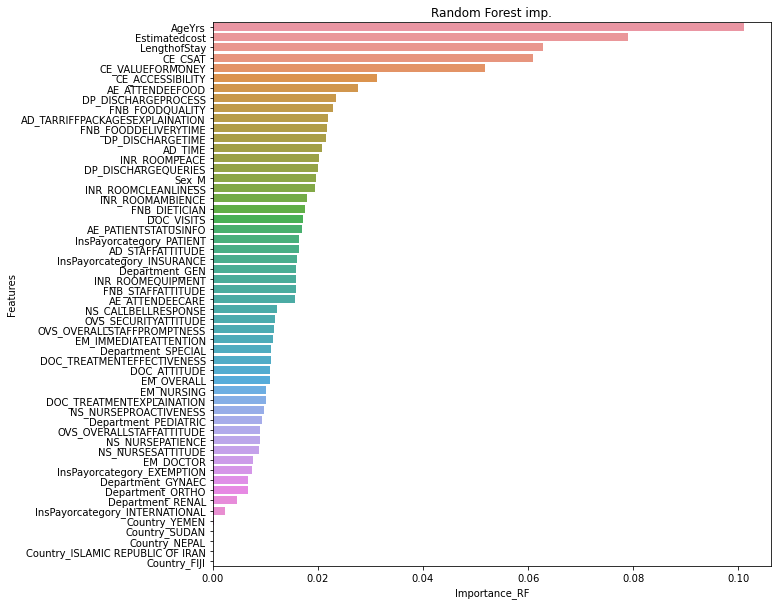

In [12]:
## Checking the "m" value of the features using random forest baseline model 
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
    
importances=forest.feature_importances_
importances=importances.tolist()

feat_labels= x_train.columns[:]
feat_labels=feat_labels.tolist()

df_imp_rf=pd.DataFrame({'Features':feat_labels,'Importance_RF':importances}).sort_values('Importance_RF', ascending=False)
#df_imp_rf

fig, ax = plt.subplots(figsize=(10, 10))

sns.barplot(x=df_imp_rf['Importance_RF'], y=df_imp_rf['Features'],orient = 'h',
           ax=ax).set_title("Random Forest imp.")

plt.show()

## No feature filtering was done even if a few feature had very low importance

## Part 1

## KNN classification model

Maximum accuracy:- 0.6942590120160214 at K = 6


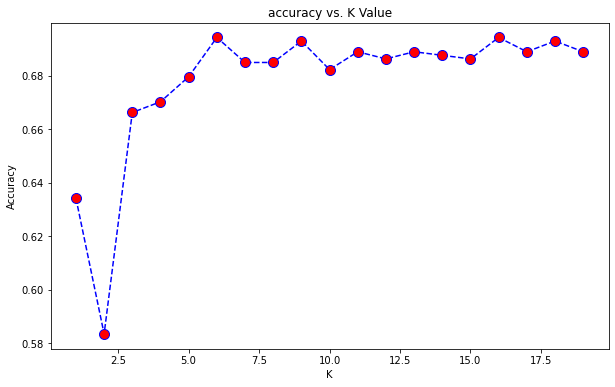

In [13]:
## Finding the optimal K value 
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)
    yhat = neigh.predict(x_test)
    acc.append(metrics.accuracy_score(y_valid, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc))+1)

In [14]:
#y_train.unique()

Accuracy (test dataset) of model  0.6942590120160214
Accuracy (train dataset) of model  0.7507075471698114
Model performance metrics
              precision    recall  f1-score   support

   Passive 0       0.59      0.46      0.52        74
  Promotor 1       0.50      0.33      0.40       199
 Detractor 2       0.75      0.88      0.81       476

    accuracy                           0.69       749
   macro avg       0.61      0.56      0.58       749
weighted avg       0.67      0.69      0.67       749

[[ 34  18  22]
 [ 16  66 117]
 [  8  48 420]]


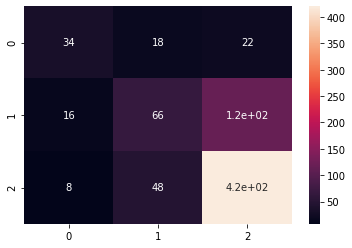

In [15]:
k = acc.index(max(acc))+1
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
Pred_y = neigh.predict(x_test)
print("Accuracy (test dataset) of model ",metrics.accuracy_score(y_valid, Pred_y))

Pred_y_train = neigh.predict(x_train)
print("Accuracy (train dataset) of model ",metrics.accuracy_score(y_train, Pred_y_train))
print("Model performance metrics")

target_names = ['Passive 0', 'Promotor 1', 'Detractor 2']
print(classification_report(y_valid, Pred_y, target_names=target_names))

cf_matrix = confusion_matrix(y_valid, Pred_y)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

### Hyper parameter tuning for CART algorithms
##### CART - Classification and regression trees

In [16]:
## Decision tree best hyperparameter set
param_grid_dt = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5, 6, 7, 8, 9, 11, 13, 15],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid_dt, verbose=True)
grid_search.fit(x_train, y_train)

final_model_dt = grid_search.best_estimator_
print(final_model_dt)

## Random forest best hyperparameter set
param_grid_rf = { 
    'n_estimators': [5, 10, 20, 30, 50, 60, 70],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4, 5, 6, 7, 8, 11, 13, 15],
    'criterion' :['gini', 'entropy']
}

rfc=RandomForestClassifier()
gridsearch_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, n_jobs=4)
gridsearch_rfc.fit(x_train, y_train)

final_model_rfc=gridsearch_rfc.best_params_
print("RF best params:",final_model_rfc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='sqrt')
RF best params: {'criterion': 'gini', 'max_depth': 15, 'max_features': 'log2', 'n_estimators': 60}


## Decision tree classifier

In [17]:
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=9, max_features='log2')
# train decision tree
dt_clf = dt_clf.fit(x_train, y_train)

y_pred = dt_clf.predict(x_test)

print("Accuracy (test dataset) of the DT model:",metrics.accuracy_score(y_valid, y_pred))

y_pred_train = dt_clf.predict(x_train)
print("Accuracy (train dataset) of the DT model:",metrics.accuracy_score(y_train, y_pred_train))

target_names = ['Passive 0', 'Promotor 1', 'Detractor 2']
print(classification_report(y_valid, y_pred, target_names=target_names))

Accuracy (test dataset) of the DT model: 0.6889185580774366
Accuracy (train dataset) of the DT model: 0.7311320754716981
              precision    recall  f1-score   support

   Passive 0       0.73      0.36      0.49        74
  Promotor 1       0.48      0.25      0.33       199
 Detractor 2       0.72      0.92      0.81       476

    accuracy                           0.69       749
   macro avg       0.64      0.51      0.54       749
weighted avg       0.66      0.69      0.65       749



## Random forest classifier

Accuracy (test dataset) of model RF is 0.7062750333778371
Accuracy (train dataset) of model RF is 0.9167452830188679
[[ 34  13  27]
 [ 15  57 127]
 [  3  35 438]]
              precision    recall  f1-score   support

   Passive 0       0.65      0.46      0.54        74
  Promotor 1       0.54      0.29      0.38       199
 Detractor 2       0.74      0.92      0.82       476

    accuracy                           0.71       749
   macro avg       0.65      0.56      0.58       749
weighted avg       0.68      0.71      0.67       749



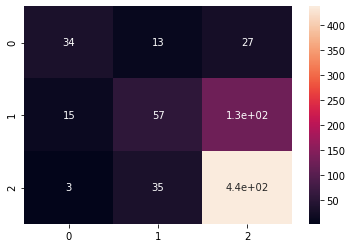

In [18]:
#rf_model = RandomForestClassifier(n_estimators=60, criterion='gini', max_depth=13, max_features='sqrt')
rf_model = RandomForestClassifier(**gridsearch_rfc.best_params_)
rf_model.fit(x_train, y_train)
predictions = rf_model.predict(x_test)

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(y_valid, predictions))

predictions_train = rf_model.predict(x_train)
print("Accuracy (train dataset) of model RF is",metrics.accuracy_score(y_train, predictions_train))

cf_matrix = confusion_matrix(y_valid, predictions)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

target_names = ['Passive 0', 'Promotor 1', 'Detractor 2']
print(classification_report(y_valid, predictions, target_names=target_names))

### Conclusion from Part 1 algorithms:

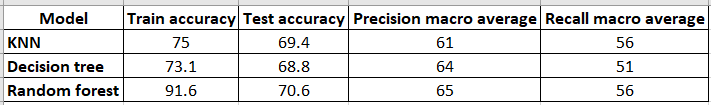

#### All the models are overfiting models and precision and recall values are less i.e. out of all predictions, how many did the model predict right is less and also at the same time, out of all the truths, how many did the model predict right is also very less.  

### --------------------------------------------------------------------------------------------------------------------------------------------------------------

## Part 2
## Over sampling technique 
### Class imbalance of the target variable
### SMOTE Random forest model - bagging technique

In [19]:
## Since Sampling should be done after VIF treated feature removal 
## Filtering the VIF removed list of columns from X 
X_vif=[]
for i in x_train:
    if i in X:
        X_vif.append(i)
        
X_vif=X[X_vif]
#X_vif

#Using SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_vif, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=split_perc, stratify=over_y)

## RF best hyperparameter set on the oversampled data
param_grid_rf = { 
    'n_estimators': [5, 10, 20, 30, 50, 60, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10,13,14],
    'criterion' :['gini', 'entropy']
}

rfc=RandomForestClassifier()
gridsearch_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, n_jobs=4)
gridsearch_rfc.fit(over_X_train, over_y_train)

final_model_rfc=gridsearch_rfc.best_params_
final_model_rfc

{'criterion': 'entropy',
 'max_depth': 14,
 'max_features': 'auto',
 'n_estimators': 100}

Model fit & predict results
Accuracy (test dataset) of model RF is 0.9118825100133512
Accuracy (train dataset) of model RF is 0.9054245283018868


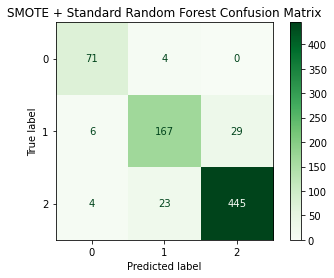

              precision    recall  f1-score   support

   Passive 0       0.88      0.95      0.91        75
  Promotor 1       0.86      0.83      0.84       202
 Detractor 2       0.94      0.94      0.94       472

    accuracy                           0.91       749
   macro avg       0.89      0.91      0.90       749
weighted avg       0.91      0.91      0.91       749



In [20]:
#Building SMOTE SRF model
#SMOTE_SRF = RandomForestClassifier(n_estimators=150, criterion='entropy', max_depth=14, max_features='auto')
SMOTE_SRF = RandomForestClassifier(**gridsearch_rfc.best_params_)

#Creating Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=250)
scoring = ('f1', 'recall', 'precision')

#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

# print('Cross validation mean results')
# print('Mean f1: %.3f' % mean(scores['test_f1']))
# print('Mean recall: %.3f' % mean(scores['test_recall']))
# print('Mean precision: %.3f' % mean(scores['test_precision']))
# print('-----------------------')
print('Model fit & predict results')

X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=split_perc, stratify=y)

#Training SMOTE RF
SMOTE_SRF.fit(over_X_train, over_y_train)

#SMOTE RF prediction 
y_pred = SMOTE_SRF.predict(X_test)

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(y_test, y_pred))
predictions_train = SMOTE_SRF.predict(X_train)
print("Accuracy (train dataset) of model RF is",metrics.accuracy_score(y_train, predictions_train))

#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=[0,1,2], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

target_names = ['Passive 0', 'Promotor 1', 'Detractor 2']
print(classification_report(y_test, y_pred, target_names=target_names))

### SMOTE adaboost model - boosting technique

Accuracy (test dataset) of model ABC is 0.6448598130841121
Accuracy (train dataset) of model ABC is 0.45495283018867927


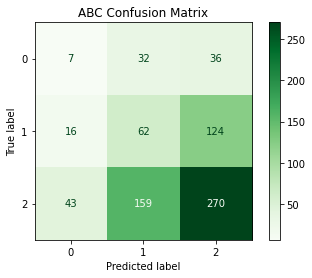

              precision    recall  f1-score   support

   Passive 0       0.51      0.48      0.50        75
  Promotor 1       0.42      0.58      0.49       202
 Detractor 2       0.82      0.70      0.75       472

    accuracy                           0.64       749
   macro avg       0.59      0.59      0.58       749
weighted avg       0.68      0.64      0.66       749



In [21]:
from sklearn.ensemble import AdaBoostClassifier

#Building SMOTE SRF model
SMOTE_ADB = AdaBoostClassifier(n_estimators=50,learning_rate=0.5)

# Train Adaboost Classifer
model = SMOTE_ADB.fit(over_X_train, over_y_train)

#Predict the response for test dataset
y_pred = model.predict(X_test)

print("Accuracy (test dataset) of model ABC is",metrics.accuracy_score(y_test, y_pred))

predictions_train = SMOTE_ADB.predict(x_train)
print("Accuracy (train dataset) of model ABC is",metrics.accuracy_score(y_train, predictions_train))

#Create confusion matrix
from sklearn.metrics import plot_confusion_matrix
fig = plot_confusion_matrix(SMOTE_ADB, x_test, y_test, display_labels=[0,1,2], cmap='Greens')
plt.title('ABC Confusion Matrix')
plt.show()

target_names = ['Passive 0', 'Promotor 1', 'Detractor 2']
print(classification_report(y_test, y_pred, target_names=target_names))


### Conclusion form Part 2 algorithms:

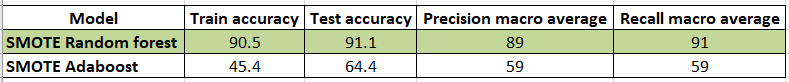

#### Oversampling random forest fits perfect and i.e. is neither over fitting nor under fitting, also the precision and recall values are on the higher side. So the business can prioritize on the target variables accordingly and take better decisions as SMOTE RF model is able to capture all the scenerios (passive, promotor, detractor) with higher accuracies.
#### Whereas, SMOTE Adaboost is a overfitting model and the model performance metrics are poor. 

### -------------------------------------------------------------------------------------------------------------------------------------------------------------

## Final conclusion / Recommendation

##### We have tried out multiple classification ML algorithms like KNN, Decision tree classifier, Random forest classifier and Over sampling random forest classifer and Adaboost classifier for predicting the NPS status.
##### Out of all these algorithms the over sampling random forest classifer model produced the best accuracy results in terms of model performance metrics (Train accuracy - 90.5% & test accuracy 91.1%)
### Finally fitting the over sampling random forest classifer model on the test data and generating the predictions on the test set 

### Test set prediction

In [22]:
#y_test

In [23]:
#len(X_train.columns)

In [24]:
test_data=pd.read_csv('nps_test.csv')
#test_data

#### Test set data preperation 
#### Making the test data schema similar to the training set data (on which model was fit)

In [25]:
test_data_df=test_data[['MaritalStatus', 'AgeYrs', 'Sex', 'BedCategory',
                       'Department', 'Estimatedcost', 'InsPayorcategory', 'State', 'Country',
                       'STATEZONE', 'CE_ACCESSIBILITY', 'CE_CSAT', 'CE_VALUEFORMONEY',
                       'EM_IMMEDIATEATTENTION', 'EM_NURSING', 'EM_DOCTOR', 'EM_OVERALL',
                       'AD_TIME', 'AD_TARRIFFPACKAGESEXPLAINATION', 'AD_STAFFATTITUDE',
                       'INR_ROOMCLEANLINESS', 'INR_ROOMPEACE', 'INR_ROOMEQUIPMENT',
                       'INR_ROOMAMBIENCE', 'FNB_FOODQUALITY', 'FNB_FOODDELIVERYTIME',
                       'FNB_DIETICIAN', 'FNB_STAFFATTITUDE', 'AE_ATTENDEECARE',
                       'AE_PATIENTSTATUSINFO', 'AE_ATTENDEEFOOD', 'DOC_TREATMENTEXPLAINATION',
                       'DOC_ATTITUDE', 'DOC_VISITS', 'DOC_TREATMENTEFFECTIVENESS',
                       'NS_CALLBELLRESPONSE', 'NS_NURSESATTITUDE', 'NS_NURSEPROACTIVENESS',
                       'NS_NURSEPATIENCE', 'OVS_OVERALLSTAFFATTITUDE',
                       'OVS_OVERALLSTAFFPROMPTNESS', 'OVS_SECURITYATTITUDE',
                       'DP_DISCHARGETIME', 'DP_DISCHARGEQUERIES', 'DP_DISCHARGEPROCESS','LengthofStay','NPS_Status']]


## List of columns for dummy/one-hot encoding
nps_testdata_dummy=test_data_df[['MaritalStatus','Sex','BedCategory','Department','InsPayorcategory'
                                 ,'State', 'Country','STATEZONE']]

## List of column(s) for label encoding
nps_testdata_lab=test_data_df[['CE_ACCESSIBILITY', 'CE_CSAT', 'CE_VALUEFORMONEY',
       'EM_IMMEDIATEATTENTION', 'EM_NURSING', 'EM_DOCTOR', 'EM_OVERALL',
       'AD_TIME', 'AD_TARRIFFPACKAGESEXPLAINATION', 'AD_STAFFATTITUDE',
       'INR_ROOMCLEANLINESS', 'INR_ROOMPEACE', 'INR_ROOMEQUIPMENT',
       'INR_ROOMAMBIENCE', 'FNB_FOODQUALITY', 'FNB_FOODDELIVERYTIME',
       'FNB_DIETICIAN', 'FNB_STAFFATTITUDE', 'AE_ATTENDEECARE',
       'AE_PATIENTSTATUSINFO', 'AE_ATTENDEEFOOD', 'DOC_TREATMENTEXPLAINATION',
       'DOC_ATTITUDE', 'DOC_VISITS', 'DOC_TREATMENTEFFECTIVENESS',
       'NS_CALLBELLRESPONSE', 'NS_NURSESATTITUDE', 'NS_NURSEPROACTIVENESS',
       'NS_NURSEPATIENCE', 'OVS_OVERALLSTAFFATTITUDE',
       'OVS_OVERALLSTAFFPROMPTNESS', 'OVS_SECURITYATTITUDE',
       'DP_DISCHARGETIME', 'DP_DISCHARGEQUERIES', 'DP_DISCHARGEPROCESS']]

## List of numerical columns for scaling 
nps_testdata_sc=test_data_df[['AgeYrs','Estimatedcost','LengthofStay']]

## Performed min-max scaling on the list of numerical columns
nps_testdata_sc_minmaxsc=minmax_scaling(nps_testdata_sc, columns=['AgeYrs','Estimatedcost','LengthofStay'])

nps_testdata_dumm_enc=pd.get_dummies(nps_testdata_dummy
                                           ,columns=nps_testdata_dummy.columns
                                           ,drop_first=True)

## Joined dummy encoded - min max scaled - label encoded dataset and created a the final encoded modelling dataset

nps_test_dumm_lab=pd.merge(nps_testdata_dumm_enc,nps_testdata_lab,left_index=True,right_index=True)

nps_test_enc_cols=pd.merge(nps_test_dumm_lab,
                       nps_testdata_sc_minmaxsc,
                       left_index=True,right_index=True)

#nps_test_enc_cols

In [26]:
X_vif_test=nps_test_enc_cols.copy()

for i in list(X_train.columns):
    if i not in list(nps_test_enc_cols.columns):
        X_vif_test[i]=0
        
X_vif_test=X_vif_test[list(X_train.columns)]

#X_vif_test

### Final model predictions - Outputs

#### Predicting on the test set by fitting on the SMOTE Random forest model and analyzing model performance

In [27]:
y_pred_test = SMOTE_SRF.predict(X_vif_test)
#y_pred_test

test_y=test_data[['NPS_Status']]

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(test_y, y_pred_test))

#Create confusion matrix
# fig = plot_confusion_matrix(SMOTE_SRF, X_vif_test, y_pred_test, display_labels=[0,1,2], cmap='Greens')
# plt.title('SMOTE + Standard Random Forest Confusion Matrix')
# plt.show()

target_names = ['Passive 0', 'Promotor 1', 'Detractor 2']
print(classification_report(test_y, y_pred_test, target_names=target_names))

Accuracy (test dataset) of model RF is 0.6401098901098901
              precision    recall  f1-score   support

   Passive 0       0.61      0.45      0.52        44
  Promotor 1       0.49      0.53      0.51       117
 Detractor 2       0.74      0.74      0.74       203

    accuracy                           0.64       364
   macro avg       0.61      0.58      0.59       364
weighted avg       0.64      0.64      0.64       364



## Code archives

### SHAP values for model evaluation

In [1]:
# import shap

# explainer=shap.TreeExplainer(SMOTE_SRF)
# shap_values=explainer.shap_values(X_test)

# shap.summary_plot(shap_values,X_test,plot_type="bar")

#### SHAP values score shows which feature was given how much importance while predicting on the test data. 
#### Comparing the SHAP value results with the EDA insights, we can claim that the busines can rely on this model since the model is giving importance to the right set of features for predicting the NPS status . 

### -------------------------------------------------------------------------------------------------------------------------------------------------------------

In [29]:
# from sklearn.ensemble import AdaBoostClassifier

# # Create adaboost classifer object
# abc = AdaBoostClassifier(n_estimators=50,
#                          learning_rate=1)
# # Train Adaboost Classifer
# model = abc.fit(x_train, y_train)

# #Predict the response for test dataset
# y_pred = model.predict(x_test)

# print("Accuracy (test dataset) of model ABC is",metrics.accuracy_score(y_valid, y_pred))

# predictions_train = abc.predict(x_train)
# print("Accuracy (train dataset) of model ABC is",metrics.accuracy_score(y_train, predictions_train))

# #Create confusion matrix
# from sklearn.metrics import plot_confusion_matrix
# fig = plot_confusion_matrix(abc, x_test, y_valid, display_labels=['<=50k','>50k'], cmap='Greens')
# plt.title('ABC Confusion Matrix')
# plt.show()

# from sklearn.metrics import classification_report
# target_names = ['<=50k','>50k']
# print(classification_report(y_valid, y_pred, target_names=target_names))

In [30]:
# nrows=(len(cat_cols.columns)+2-1)//2
# fix, axes=plt.subplots(ncols=2,nrows=nrows,figsize=(8*2,6*nrows), sharey=True)
# axes_it=axes.flat
# for col,ax in zip(cat_cols.columns, axes_it):
#     plot=sns.histplot(x=col
#                 ,data=cat_cols[cat_cols.columns==col]
#                 ,ax=ax)
# #     display_figures(plot,df_reg_custseg[df_reg_custseg['Region']==col],'pct_return')
#     plot.set(title=col)

# for ax in axes_it:   # if number of columns not multiple of ncols, hide remaining axes
#     ax.axis('off')

# plt.show()

In [31]:
# Checking distribution of numerical data
# cat_cols=['MaritalStatus', 'AgeYrs', 'Sex', 'BedCategory',
#        'Department', 'InsPayorcategory', 'State', 'Country',
#        'STATEZONE', 'CE_ACCESSIBILITY', 'CE_CSAT', 'CE_VALUEFORMONEY',
#        'EM_IMMEDIATEATTENTION', 'EM_NURSING', 'EM_DOCTOR', 'EM_OVERALL',
#        'AD_TIME', 'AD_TARRIFFPACKAGESEXPLAINATION', 'AD_STAFFATTITUDE',
#        'INR_ROOMCLEANLINESS', 'INR_ROOMPEACE', 'INR_ROOMEQUIPMENT',
#        'INR_ROOMAMBIENCE', 'FNB_FOODQUALITY', 'FNB_FOODDELIVERYTIME',
#        'FNB_DIETICIAN', 'FNB_STAFFATTITUDE', 'AE_ATTENDEECARE',
#        'AE_PATIENTSTATUSINFO', 'AE_ATTENDEEFOOD', 'DOC_TREATMENTEXPLAINATION',
#        'DOC_ATTITUDE', 'DOC_VISITS', 'DOC_TREATMENTEFFECTIVENESS',
#        'NS_CALLBELLRESPONSE', 'NS_NURSESATTITUDE', 'NS_NURSEPROACTIVENESS',
#        'NS_NURSEPATIENCE', 'OVS_OVERALLSTAFFATTITUDE',
#        'OVS_OVERALLSTAFFPROMPTNESS', 'OVS_SECURITYATTITUDE',
#        'DP_DISCHARGETIME', 'DP_DISCHARGEQUERIES', 'DP_DISCHARGEPROCESS','LengthofStay']

# for i in cat_cols:
#     hist=px.histogram(nps,x=i)
#     hist.update_layout(
#                         autosize=False,
#                         width=500,
#                         height=400)
#     hist.show()

In [32]:
# lin_dep_df=nps.select_dtypes(exclude='object')
# if len(lin_dep_df.columns)%2!=0:
#     nrows=(len(lin_dep_df.columns)//2)+1
# else:
#     nrows=(len(lin_dep_df.columns)//2)
# nrows,len(lin_dep_df.columns)

In [33]:
# lin_dep_df=nps.select_dtypes(exclude='object')
# if len(lin_dep_df.columns)%2!=0:
#     nrows=(len(lin_dep_df.columns)//2)+1
# else:
#     nrows=(len(lin_dep_df.columns)//2)
# figure, axes = plt.subplots(nrows, 2,figsize=(30, 150),constrained_layout = True,sharey=True)
# col_list=list(lin_dep_df.columns)
# col_list.remove('CE_NPS')
# nrow=0
# figure.suptitle('LINEAR DEPENDENCY CHECK')
# gc=0
# for i in range(len(col_list)):
#     ncol=i%2
#     if(lin_dep_df[col_list[i]].nunique()>20):
#         sns.regplot(data=lin_dep_df,x=col_list[i],y=lin_dep_df['CE_NPS'],ax=axes[nrow][ncol],ci=100)
#         gc+=1
#         axes[nrow][ncol].set_title('Linear Dependency - '+col_list[i]+' vs NPS')
#     if(ncol==1):
#         nrow+=1
        
# # axes[1,2].set_axis_off()
# print(gc,len(lin_dep_df.columns))        
# for i in range(1,len(lin_dep_df.columns)+1-gc):
#     g=0-i
#     #print(g)
#     axes.flat[g].set_visible(False)
# plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})
# sns.lmplot(x='mpg', y='disp', data=lin_dep_df)
# plt.title("Scatter Plot with Linear fit")

In [34]:
# import numpy as np
# import pandas as pd
# import plotly.express as px
# import plotly.figure_factory as ff
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go

# # df = pd.DataFrame({'2012': np.random.randn(20),
# #            '2013': np.random.randn(20)+1})
# # df['2012'].iloc[0] = np.nan

# # df = df.reset_index()
# # dfm = pd.melt(df, id_vars=['index'], value_vars=df.columns[1:])
# # dfm = dfm.dropna()

# # dfm.rename(columns={'variable':'year'}, inplace = True)
# cols = cat_cols.columns.unique()
# nrows = len(cols)

# fig = make_subplots(rows=nrows, cols=2)

# for r, col in enumerate(cols, 1):
#     dfs = cat_cols[cat_cols[cols]==col]
#     fx1 = ff.create_distplot([cat_cols[col].values], ['distplot'],curve_type='kde')
#     fig.add_trace(go.Scatter(
#                                 x= fx1.data[1]['x'],
#                                 y =fx1.data[1]['y'],
#                               ), row = r, col = 1)

# fig.show()